# 3. Training a Neural Network - Approximation of Target Functions 

The last notebook showed that neural networks can produce very complicated functions. By carefully and purposefully choosing the weights in the respective layers, specific functions can be constructed and/or approximated.

## Training

The training of a neural network can roughly be undertood as curve fitting, with the difference being that there are potentially millions of parameters in the form of weight matrices, that have to be tuned. Naturally there must be a great pool of samples to be used for the training to mitigate uncertainties.

When approximating a target function there's bound to be a deviation, which is given by the so called *cost function* also knows as the *loss function*:

### $(1) \,\,\, C(w) = \frac{1}{2} \left< \| f_{approx}(y^{in}) - F(y^{in}) \|^{2} \right>$

Or for a finite number of samples:

### $ (2) \,\,\, C(w) \approx \frac{1}{2} \frac{1}{N} \sum\limits_{N} \| f_{approx}(y^{s}) - F(y^{s}) \|^{2}$

$F$: target function   
$f_{approx}$: approximate function

Minimizing the cost function will yield the approximate function with the best fit (least-squares fitting). Minimization, of course, follows the principle to determine the gradient of the function and finding it's root. Since the number of samples, though finite, might still be too large for the averaging in reasonable time scales, only a small batch of the samples is actually being used to determine the cost. This is knows as *stochastic gradient descent*. THe stochastic selection is not being utilized just yet, since the data load is still managable. From certain starting weights new weights are determined by making a step along the gradient:

### $ (3) \,\,\, w_{i} \mapsto w_{i} - \eta \frac{\partial \tilde{C}(w)}{\partial w_{i}}$

$\eta$: approximation step size / learning rate

Iterating over this process will ultimately yield an arbitrarily close approximation of the target weights that are necessary to construct the target function.

In this exemplary notebook the same neural network from the last notebook will be expanded to allow for training. The parts carried over from the previous notebook are already modified to account for backpropagation. What this is will be elaborated on in the second chapter of this notebook.

In [1]:
# all the imports

import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [2]:
# two input values and only one output value

# dimensions of input, hidden and output layers
N0 = 2
N1 = 30
N2 = 1

In [3]:
# activation function

# smooth function, returns values between 0 and 1
def sigmoid(x):
    
    # both calculations for forward and backpropagation are being performed 
    # in the same step when calling this function
    
    s = 1 / (1 + np.exp(-x)) # nonlinear function for forward propagation
    ds = np.exp(-x) * s**2   # derivative for backward propagation
    
    return s, ds

In [4]:
# output function

# dictionary containing activation functions 
# the theta function has been remoed for simplicity
# using a dictionary is this instance is unnecessary

activation_dict = {"sigmoid": sigmoid}

# operations performed at each layer
def layer(act, v, w, b):
    
    z = np.dot(v, w) + b           # linear superposition of all neurons from the previous layer
    return activation_dict[act](z) # application of nonlinear function and calculation of the derivative


In an effort to automate and compactify the way the weight matrices and biases are being initiated and used, a list with the respective layer sizes is used which characterises the structure of the network. Lists have also been made for the weights and biases which include the objects for the respective layers including the input and output layer. This ultimately simplifies the `network_multi` function, though, functionally nothing has changed.

In [5]:
# making a network with n hidden layers

# number of hidden layers, minimum number of hidden layers to be used: 1
layer_count = 4

# size of all the layers in a list, this includes input and output layers
layers = [N0]

for l in range(layer_count):
    layers.append(N1)
    
layers.append(N2)

print("Layer structure of the network: ", layers)


# weights and biases used for transitions between the layers including the input and output layer
weights = [np.random.uniform(low = -10, high = +10, size = (layers[k], layers[k+1])) for k in range(len(layers)-1)]
bias = [np.random.uniform(low = -1, high = +1, size = (layers[k+1])) for k in range(len(layers)-1)]

# propagation through a network with at least one hidden layer
def network_multi(y_in, activation, n):
    
    # storage arrays
    layer_vals = [np.empty((M**2, layers[j])) for j in range(len(layers))]       # values (forward propagation)
    layer_vals_df = [np.empty((M**2, layers[j])) for j in range(1, len(layers))] # derivatives (backward propagation)    
    
    y_vals = y_in
    layer_vals[0] = y_vals
    
    for i in range(n+1):
        y_vals, y_df = layer(activation, y_vals, weights[i], bias[i])
        layer_vals[i+1] = y_vals
        layer_vals_df[i] = y_df
    
    return layer_vals, layer_vals_df

Layer structure of the network:  [2, 30, 30, 30, 30, 1]


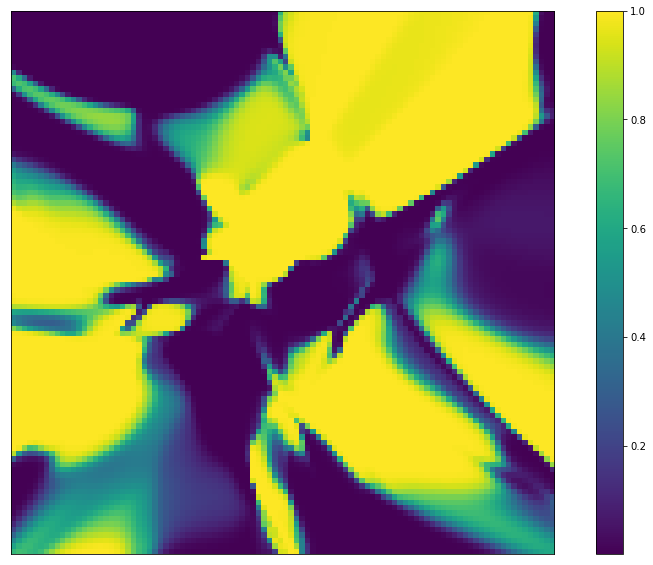

In [6]:
# visualize the source image

M = 100

# input data
y1, y2 = np.meshgrid(np.linspace(-0.5, 0.5, M), np.linspace(-0.5, 0.5, M))

y1_flat = y1.flatten()
y2_flat = y2.flatten()

y_in = np.empty((len(y1_flat), 2))
y_in[:,0] = y1_flat
y_in[:,1] = y2_flat

plotmatrix = network_multi(y_in, "sigmoid", layer_count)[0][-1]
plotmatrix = np.reshape(plotmatrix[:, 0], (M, M))

# plot source image
plt.figure(figsize = (15, 10), facecolor = "white")

plt.imshow(plotmatrix, origin = "lower")
plt.colorbar()

plt.xticks([], [])
plt.yticks([], [])

plt.show()


Up until this point nothing in the code has changed except also calculating the derivatives and storing these values in addition to the values of the neurons.

## Backpropagation

Now we have come to the part of the notebook where the approximation of a function through the training of the neural network is actually being performed. You may have noticed the modifications of some functions which now, in addition to calculating the values of the neurons, also calculate derivatives which will be coming in handy for the next parts. The approximation/training is performed by gradient descent and this is what we will be focusing on in this second part.

Some theory first $\,$ ಠ_ಠ

We will only be using a small number of batches to approximate a target function in this exemplary notebook, so the full cost function will be used in the following. To further adjust to the shown example the approximate function will be specified to be the nonlinear function (sigmoid) acting on the linear superposition.

Determining the gradient is accomplished with a process known as backpropagation. In an analytical calculation of the gradient the chain rule is exploited:

### $(4) \,\,\, \frac{\partial C(w)}{\partial w_{*}} = \frac{\partial}{\partial w_{*}} \sum\limits_{i} (f(z^{(n)}_{i}) - F(z^{(n)}_{i}))^{2} = \sum\limits_{i} (f(z^{(n)}_{i}) - F(z^{(n)}_{i})) \cdot f^{'}(z^{(n)}_{i}) \cdot \frac{\partial z^{(n)}_{i}}{\partial w_{*}}$

$w_{*}$: a weight or bias variable in the network     

Notice how $z^{(n)}_{i}$ is the linear superposition of all the previous neurons $y^{(n-1)}_{i}$. Thus the differentiation of $z^{(n)}_{i}$ can be expressed as:

### $(5) \,\,\, \frac{\partial z^{(n)}_{i}}{\partial w_{*}} = \sum\limits_{j} \frac{\partial z^{(n)}_{i}}{\partial y^{(n-1)}_{j}} \frac{y^{(n-1)}_{j}}{w_{*}} = \sum\limits_{j} w^{(n, n-1)}_{ij} f^{'}(z^{(n-1)}_{j}) \frac{\partial z^{(n-1)}_{j}}{\partial w_{*}}$

$z^{(n-1)}_{j}$: superposition variable of neuron $j$ in the lower $(n-1)$ layer.

This Spiel can now be continued until the terms explicitly containing the variable $w_{*}$, in regards to which we are calculating the derivative, can is found. By doing this the whole neural network is propagated through in reverse giving the method it's name *backpropagation*.

Formally the expression 

### $(6) \,\,\, w^{(n, n-1)}_{ij} f^{'}(z^{(n-1)}_{j})$

can be understood as matrix multiplication and can be written in the more compact form:

### $(7) \,\,\, w^{(n, n-1)}_{ij} f^{'}(z^{(n-1)}_{j}) = M^{(n, n-1)}_{ij}$

This yields the following repeated matrix multiplication:

### $(8) \,\,\, \frac{\partial z^{(n)}_{i}}{\partial w_{*}} = \sum\limits_{j, k, ..., u, v} M^{(n, n-1)}_{ij} M^{(n-1, n-2)}_{jk} \cdot \cdot \cdot M^{(\tilde{n}+1, \tilde{n})}_{u,v} \cdot \frac{\partial z^{(\tilde{n})}_{v}}{\partial w_{*}}$

$z^{(\tilde{n})}_{v}$: superposition variable which is in explicit dependence of $w_{*}$

Substituting equation $(8)$ into equation $(4)$ and viewing the first two factors as a vector, the derivative of the cost function turns out to be a repeated vector/matrix - matrix multiplication:

### $(9) \,\,\, \frac{\partial C(w)}{\partial w_{*}} = \sum\limits_{i, j, k, ..., u, v} \Delta_{i} \cdot M^{(n, n-1)}_{ij} M^{(n-1, n-2)}_{jk} \cdot \cdot \cdot M^{(\tilde{n}+1, \tilde{n})}_{u,v} \cdot \frac{\partial z^{(\tilde{n})}_{v}}{\partial w_{*}}$

#### To summerize:

%%% Write a summary here %%%

Now on to the practical application! $\,$ (っ◔◡◔)っ

The function `backward_step` performs the vector - matrix multiplication as written in equation $(9)$. The argument `delta` is the result of the previous vector - matrix multiplication where the matrix is comprised of the weights and derivatives of the respective layers following equation $(7)$:

### $(10) \,\,\, \Delta_{j} = \sum\limits_{i} \Delta_{i} M^{(n, n-1)}_{ij}$

In [7]:
# backward step to carry out the vector - matrix multiplication

def backward_step(delta, w, df):
    
    return np.dot(delta, np.transpose(w)) * df

In [8]:
# backpropagation algorithm

# the number of gradient steps that will be performed to minimize the cost function
batches = 2000

def backpropagation(y_nn, y_nn_df, y_target):
    
    # storage lists for gradient desent
    dw = [np.empty((layers[j], layers[j+1])) for j in range(len(layers)-1)] # weights gradient
    db = [np.empty((layers[j+1])) for j in range(len(layers)-1)]            # bias gradient
    
    # initial delta_i from equation (9)
    delta_y = (y_nn[-1] - y_target) * y_nn_df[-1]
    
    
    dw[-1] = np.dot(np.transpose(y_nn[-2]), delta_y) / M**2
    db[-1] = delta_y.sum(0) / M**2
    
    for i in range(len(layers) - 2):
        
        delta_y = backward_step(delta_y, weights[-1-i], y_nn_df[-2-i])
        dw[-2-i] = np.dot(np.transpose(y_nn[-3-i]), delta_y) / M**2
        db[-2-i] = delta_y.sum(0) / M**2
        
    return dw, db
    

The function `gradient_step` carries out one step in the gradient descent. With every single time the function is called, all the weights and biases are adjusted such to approximate the weights and biases necessary to construct the target image following equation $(8)$.

In [9]:
# gradient descent

def gradient_step(eta, dweights, dbias):
    
    for i in range(len(layers) - 1):
        weights[i] -= eta * dweights[i]
        bias[i] -= eta * dbias[i]

The function `train_net` is the overarching function which completes one full cycle of forward and backward propagation. It also takes the target function as an argument which is to be used by the function `backpropagation` and the calculation of the cost. Every single time `train_net` is being called it acts on new/different weights and biases which are altered by the function itself.

In [10]:
# this is the part where the network is beign trained

def train_net(y, y_target, activation, n):
    
    # forward propagation: calculation of neuron values and derivatives
    y_out, y_out_df = network_multi(y, activation, n)  
    y_target = np.reshape(y_target, (M**2, 1))
    
    # backpropagation: calculation of the gradient and performing the gradient step
    dw, db = backpropagation(y_out, y_out_df, y_target)
    gradient_step(0.5, dw, db)
    
    # calculation of the cost function
    cost = ((y_target - y_out[-1])**2).sum() / M**2
        
    return cost, y_out[-1]

The target function to be approximated in this exemplary notebook is chosen to be an image with the dimensions $M \times M$. It is dark purple (0) in the upper left and lower right quadrant and yellow (1) everywhere else making a $2 \times 2$ chess tile.

After the initiation of the network it is being trained iteratively 2000 times. The outputs are stored in arrays to be plotted later on. Notice that training is performed on the identical input data. In practice, when training a neural network to identify certain features in the input data say cats vs. dogs or a Higgs event, this is not desirable as the network would just "learn this specific set of input data by heart" thus leaving the network incapable of recognizing the features alternate input data. For the approximation of a target image, though, this is exactly how it should be.

In [11]:
# construction of target image
target = np.zeros((M, M))
quad_1 = np.ones((M//2, M//2))
target[:M//2, M//2:] = quad_1
target[M//2:, :M//2] = quad_1

# storage helper arrays
costs = np.empty(batches)
images = [None] * batches

# iterative training
for i in range(batches):
    
    costs[i], images[i] = train_net(y_in, target, "sigmoid", layer_count)

<IPython.core.display.Javascript object>


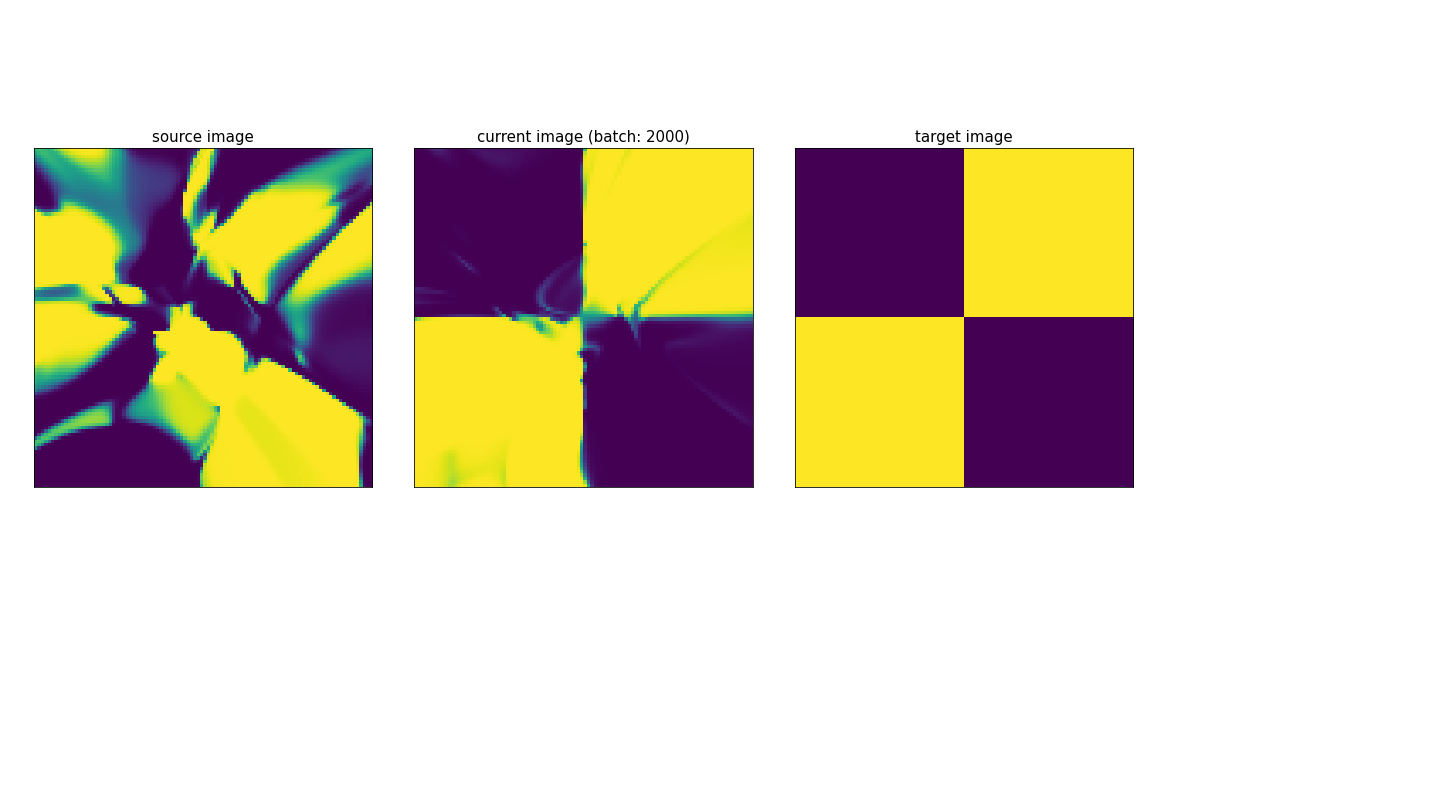

In [17]:
# make an animation out of all the images from the approximation process.

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

#plt.rcParams['figure.dpi'] = 

fig = plt.figure(figsize = (16, 9), facecolor = "white")
fig.canvas.toolbar_visible = False
fig.show()

ax_start = fig.add_subplot(131)
ax_current = fig.add_subplot(132)
ax_target = fig.add_subplot(133)

plt.tight_layout()

#plt.ion()
ax_start.imshow(np.reshape(images[0][:, 0], (M, M)))
ax_start.set_title('source image', fontsize = 15)
ax_start.set_xticks([], [])
ax_start.set_yticks([], [])

ax_target.imshow(target)
ax_target.set_title('target image', fontsize = 15)
ax_target.set_xticks([], [])
ax_target.set_yticks([], [])
#plt.ioff()

for i in range(batches):
    
    ax_current.cla()
    
    ax_current.set_title(f'current image (batch: {i+1})', fontsize = 15)
    ax_current.imshow(np.reshape(images[i][:, 0], (M, M)))
    ax_current.set_xticks([], [])
    ax_current.set_yticks([], [])
    fig.canvas.draw()
    #sleep(0.001)
    
    # plt.savefig(f"out2000\\nn_image_{i+1}", dpi = 150, facecolor = "white")
    
plt.close(fig)

Isn't this cool? 

Now we can dynamically see how this approximation is actully being carried out. A very important variable which determines how this animation plays out, is the approximation step size or learning rate $\eta$. Naturally, to accelerate the learning procedure a large learning rate would be chosen. This way the approximation progresses quicker but runs the risk of overshooting the local minimum of the approximation and potentially even decreasing the precision of the approximation. After a certain number of iterations you would often times see the network image oscillating, incapable of further approximation. This is due to the approximation step being greater than the distance to the local minimum which leads to gradient descent overshooting the minimum back and forth and resulting in the oscillation of the image.

To combat this and ultimately achieve a better approximation, a smaller learning rate can be chosen which comes at the cost of slower learning. 

These two scenarios can be understood as the instances of an underdampened and overdampened harmonic oscillator as shown in the image below where the yellow line corresponds to an underdampened HO and the red corresponds an overdampened HO (alongside the blue line corresponding to an undampened HO). Both of the scenarios are not yielding ideal learning. The best learning rate is chosen such that it reaches the minimum cost as quickly as possible without overshooting it. This would match the green line in the image.

<img src="images/dampedharmosc.JPG" width = 500>

Choosing the correct learning rate is tricky to say the least. We will go deeper into how to set the learning rate later on. But for now the learning rate we have chosen in the code above is good enough for demonstrational purposes as very nicely visable in the plot of the cost function down below.

<IPython.core.display.Javascript object>


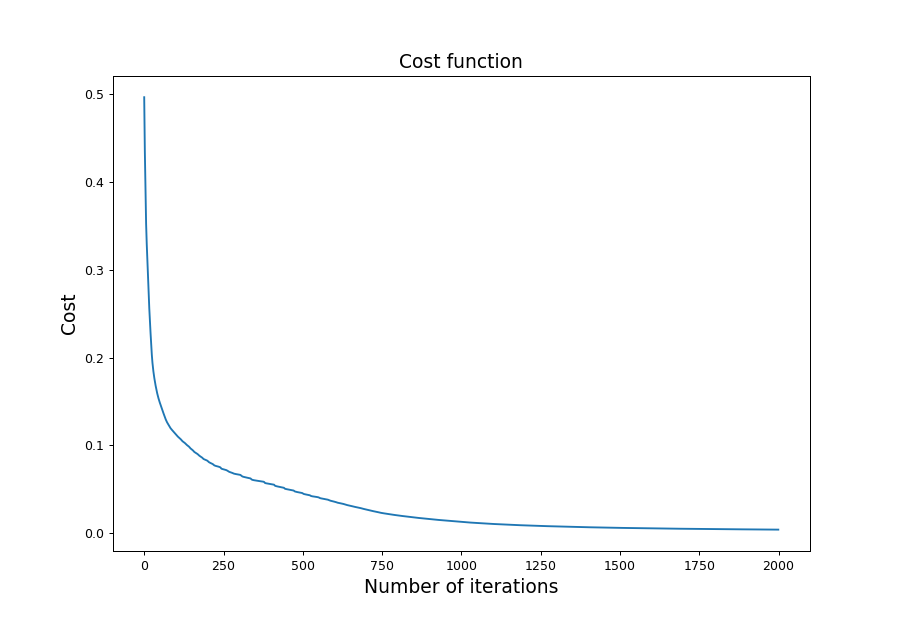

In [15]:
# plot of the cost function

plt.figure(figsize = (10, 7), facecolor = 'white')

plt.ioff()
plt.plot(costs)

plt.title("Cost function", fontsize = 15)
plt.xlabel("Number of iterations", fontsize = 15)
plt.ylabel("Cost", fontsize = 15)

plt.show()

In the upcoming notebook we will rebuild our neural network in Keras learning the basic principles of how to use the package so that we can simply the network making process to further focus on the physics at hand. So tune in for the next notebook, see ya nerds!

## Image sources

[Dampened harmonic oscillator](    
https://files.mtstatic.com/site_4539/15300/0/webview?Expires=1656001737&Signature=AwgbwVWhwm1jBXq~xR~8cyLoKaGfeK~8uUr0SCxOeFl-LYDu2OwzXBCbxZIMWyd7xIsN~ucnlCyMuVBLQen8JEC4jldEAm-t-RRkGchndxWWahUIfyJhsjtw1vU~fRDmhaexzNXtBNLjHVmHSJ1eIAex6XnK95pUsj2WEQAF84U_&Key-Pair-Id=APKAJ5Y6AV4GI7A555NA)